<a href="https://colab.research.google.com/github/josephmhernandez/Deep-Learning/blob/master/HousingPricesregression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.datasets import boston_housing


(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [0]:
#For no more tensor flow warnings. 
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

In [15]:
train_data.shape

(404, 13)

In [16]:
test_data.shape

(102, 13)

In [17]:
#We can see that we are not training a DL model for regression, not classification.
#The target values are no longer classes, they are continuous data points (Price). 
print(train_targets.shape)
train_targets[1:10]

(404,)


array([42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

In [0]:
#Normalize the data to a mean of 0 and variance of 1. Neural network input need
# need to be about the same range. By normalizing the data we keep the same 
# information, but we condense it down to the same range across features. 
# Normalize: (xi - xbar) / (std. dev) 

mean = train_data.mean(axis=0)
std = test_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std


In [0]:
from keras import models 
from keras import layers

def build_model(): 
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation = 'relu'))

  #Last layer of the NN is a single unit with no activation. This is the typical
  # set up for scalar regression (predicting a single continuous value). 
  model.add(layers.Dense(1))

  model.compile(optimizer = 'rmsprop', loss='mse', metrics=['mae'])
  
  return model



In [20]:
#Validating your approach using K-fold validation. 
#Because we have so few data points <500 in this case, we will use k-fold 
#  validation. If we don't do this our validation set will only be ~100 points
#  which isn't large enough.
#The validation score of this model will be the average of the K validation
#  scores. 

import numpy as np
k = 4 
num_val_samples = len(train_data) // k 

#Training at a rediculuously large number of epochs so we can plot overfitting. 
num_epochs = 500
all_mae_histories = []

for i in range(k): 
  print('process fold #', i)
  val_data = train_data[i*num_val_samples: (i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]

  partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis=0)

  model = build_model()

  history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs= num_epochs, batch_size=1, verbose=0)
  mae_history = history.history['val_mean_absolute_error']

  all_mae_histories.append(mae_history)






process fold # 0
process fold # 1
process fold # 2
process fold # 3


In [0]:
#Get average validation data. 
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]


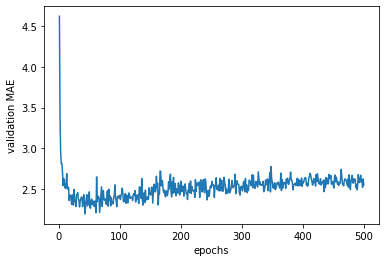

In [26]:
#Graph Validation data. 
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history) 
plt.xlabel('epochs')
plt.ylabel('validation MAE')
plt.show()

In [0]:
#Validation is too noisy (Variance too high). So, we are going to smooth out
#  the curve and omit the first couple of epochs that we know are necessary to
#  train the model. 

def smooth_curve(points, factor=.9):
  smoothed_points = []
  for point in points: 
    #print(point)
    if smoothed_points: 
      previous = smoothed_points[-1]
      #print(previous)
      smoothed_points.append(previous*factor + point * (1-factor))
    else:
      smoothed_points.append(point)
    
  return smoothed_points



490


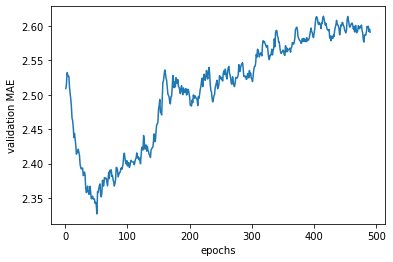

In [39]:
smooth_mae_history = smooth_curve(average_mae_history[10:])
print(len(smooth_mae_history))
#Skips the first 10 points, because based on the previous graph we know we need 
#  to train at least 10 epochs.  
plt.plot(range(1,len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('epochs')
plt.ylabel('validation MAE')
plt.show()


After looking at the training and validation data, we come to the conclusiont that we should be training with about 80 epochs to minimize validation loss. 

In [41]:

model = build_model()

model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print('test_mse_score:', test_mse_score)
print('test_mae_score:', test_mae_score)

102/102 [==============================] - 0s 1ms/step
test_mse_score: 15.5699836880553
test_mae_score: 2.553229958403344


In [0]:
'''
Based on these results, we are about $2,553 off from out actual results. 

The housing prices were in the range of about $10,000 to $50,000
'''
